In [64]:
# Libraries imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, roc_curve, auc
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [65]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [66]:
# Data loading
ER_data = pd.read_csv('ER.csv')

In [67]:
# First few rows of the data.
ER_data.head()

Year  DoY  Hour       ER   Rg  Tair  Tsoil     rH     VPD  Ustar   SWC
0  2019   91   0.5  1.16305  0.0  2.57   9.73  73.91 -9999.0   0.05  0.31
1  2019   91   1.0  0.84226  0.0  2.56   9.39  73.33 -9999.0   0.03  0.31
2  2019   91   1.5  1.84811  0.0  1.88   9.12  76.41 -9999.0   0.02  0.31
3  2019   91   2.0  1.12012  0.0  1.78   8.83  74.55 -9999.0   0.03  0.31
4  2019   91   2.5  1.25492  0.0  1.84   8.57  68.79 -9999.0   0.03  0.31

In [68]:
ER_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65807 entries, 0 to 65806
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    65807 non-null  int64  
 1   DoY     65807 non-null  int64  
 2   Hour    65807 non-null  float64
 3   ER      32288 non-null  float64
 4   Rg      65807 non-null  float64
 5   Tair    65807 non-null  float64
 6   Tsoil   65807 non-null  float64
 7   rH      65807 non-null  float64
 8   VPD     65807 non-null  float64
 9   Ustar   65807 non-null  float64
 10  SWC     45908 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 5.5 MB


In [69]:
# Number of years data available
ER_data['Year'].unique()

array([2019, 2020, 2021, 2022], dtype=int64)

In [70]:
import datetime

# Function to Create Date column
def create_date(row):
    """
    Create a date string in the format 'YYYY-MM-DD' from a row of a DataFrame with 'day' and 'year' columns.
    """
    date = datetime.datetime.strptime(f"{int(row['Year'])}-01-01", "%Y-%m-%d") + datetime.timedelta(days=row['DoY'] - 1)
    return date.strftime("%Y-%m-%d")

In [71]:
# Creating Date column 

ER_data["Date"]=ER_data.apply(create_date,axis=1)

In [72]:
# Replace missing values with Nan.

ER_data.replace(-9999.00, np.nan, inplace=True)

In [73]:
# Store rows if more than or equal to 6 column values are missing in a row.

data = ER_data[ER_data.isnull().sum(axis=1) >= 6]
index= list(data.index)

In [74]:
# First few rows of missing data.
data.head()

Year  DoY  Hour    ER  Rg  Tair  Tsoil  rH  VPD  Ustar  SWC        Date
254  2019   96   7.5   NaN NaN   NaN    NaN NaN  NaN    NaN  NaN  2019-04-06
255  2019   96   8.0   NaN NaN   NaN    NaN NaN  NaN    NaN  NaN  2019-04-06
338  2019   98   1.5  3.68 NaN   NaN    NaN NaN  NaN    0.1  NaN  2019-04-08
339  2019   98   2.0   NaN NaN   NaN    NaN NaN  NaN    NaN  NaN  2019-04-08
340  2019   98   2.5   NaN NaN   NaN    NaN NaN  NaN    NaN  NaN  2019-04-08

## Violin plot

To see the distribution of each columns.

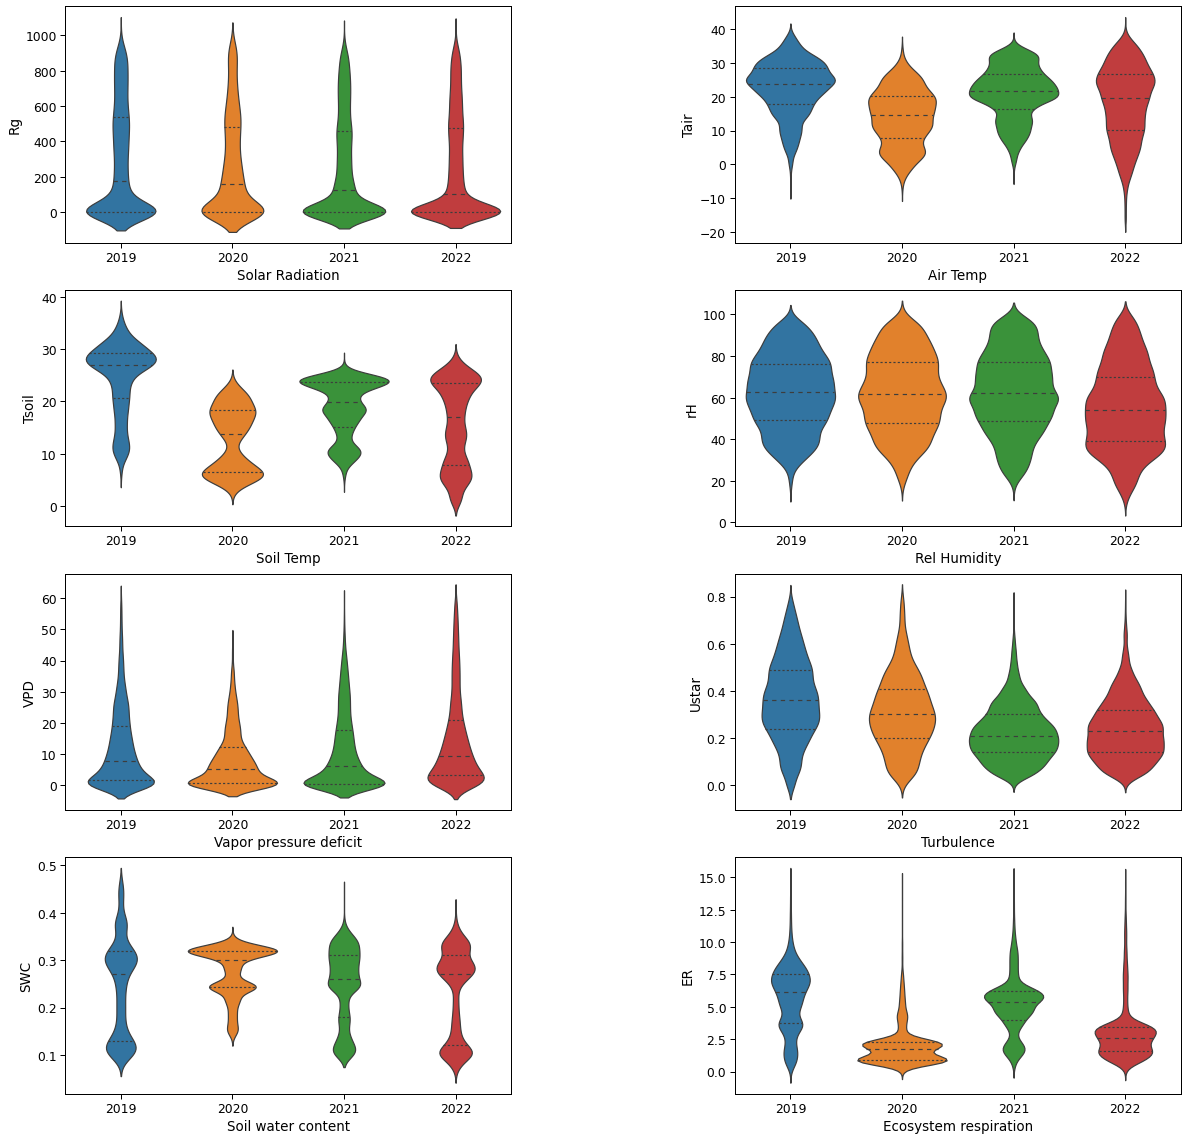

In [75]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

plt.subplots_adjust(wspace=0.5) 

sns.violinplot(x='Year',y='Rg',data=df,inner = "quartile",ax=ax[0][0])
ax[0][0].set_xlabel('Solar Radiation')

sns.violinplot(x='Year',y='Tair',data=df,inner = "quartile", ax=ax[0][1])
ax[0][1].set_xlabel('Air Temp')

sns.violinplot(x='Year',y='Tsoil',data=df,inner = "quartile", ax=ax[1][0])
ax[1][0].set_xlabel('Soil Temp')

sns.violinplot(x='Year',y='rH',data=df, inner = "quartile",ax=ax[1][1])
ax[1][1].set_xlabel('Rel Humidity')

sns.violinplot(x='Year',y='VPD',data=df,inner = "quartile", ax=ax[2][0])
ax[2][0].set_xlabel('Vapor pressure deficit')

sns.violinplot(x='Year',y='Ustar',data=df,inner = "quartile", ax=ax[2][1])
ax[2][1].set_xlabel('Turbulence')

sns.violinplot(x='Year',y='SWC',data=df,inner = "quartile", ax=ax[3][0])
ax[3][0].set_xlabel('Soil water content')

sns.violinplot(x='Year',y='ER',data=df,inner = "quartile", ax=ax[3][1])
ax[3][1].set_xlabel('Ecosystem respiration')


    
plt.show()

In [76]:
# Remove missing data from ER_data.
df = ER_data.drop([ER_data.index[i] for i in index])

In [77]:
# Drop rows if ER value is missing.
df= df.dropna(subset=['ER'])

In [78]:
# Remaining missing values in each column.
df.isna().sum()

Year        0
DoY         0
Hour        0
ER          0
Rg        406
Tair      347
Tsoil     406
rH        347
VPD      1759
Ustar      76
SWC      1574
Date        0
dtype: int64

In [79]:
# Removing outliers
df=df[(df['ER'] >= 0) & (df['ER']<15)]
df=df[df['VPD']<60]
df=df[df['Ustar']<0.8]

In [80]:
df=df[['Date','Year', 'DoY', 'Hour', 'Rg', 'Tair', 'Tsoil', 'rH', 'VPD',
       'Ustar', 'SWC','ER']]

## Visualizations

### Histogram plot

Text(0.5, 0, 'Ecosystem Respiration')

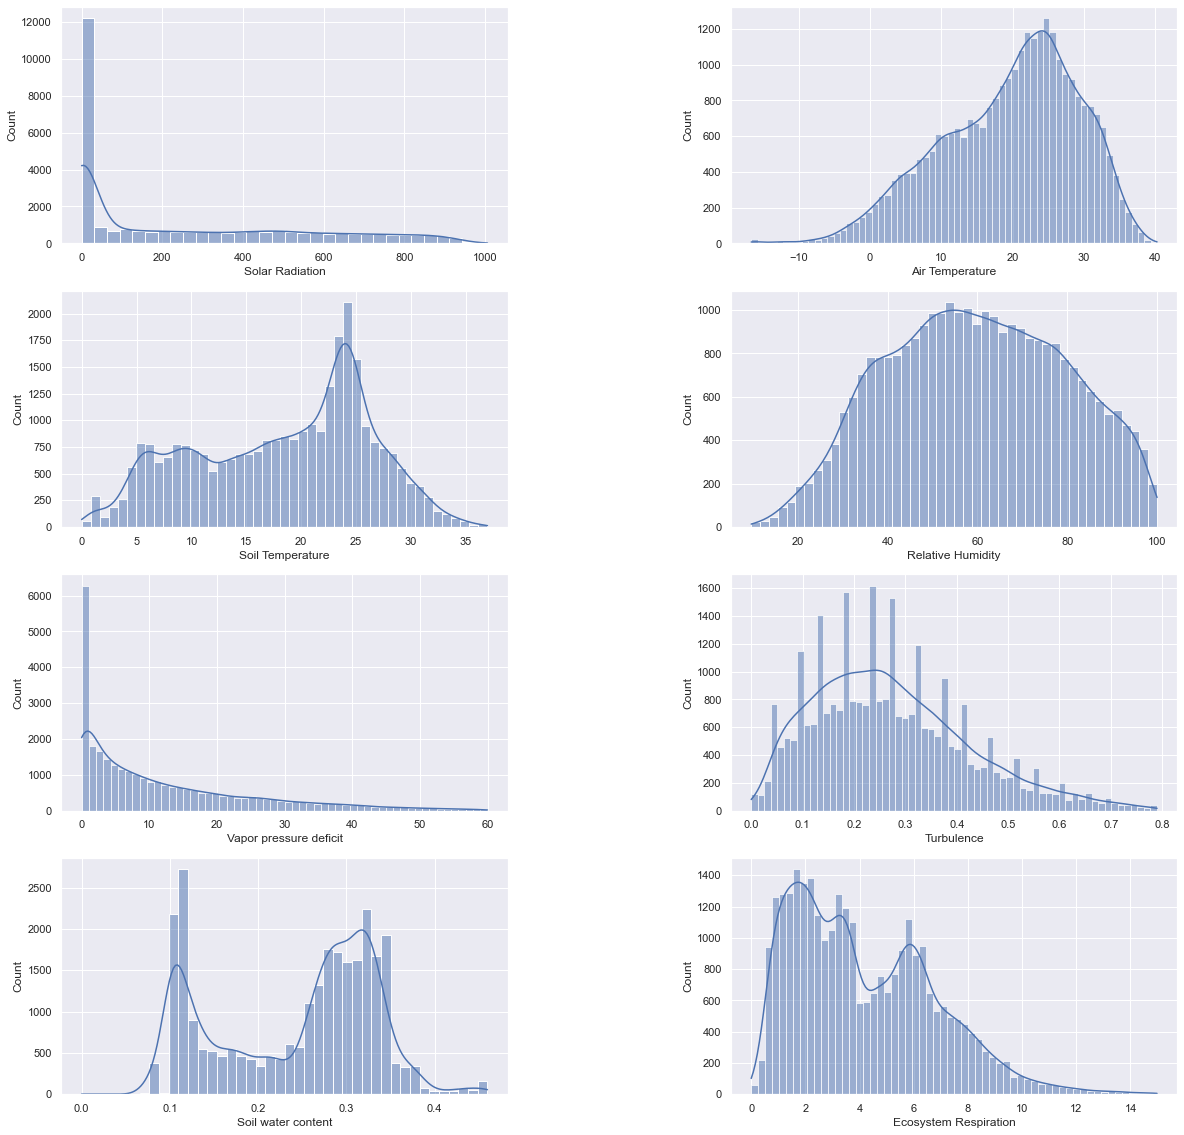

In [81]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize = (20, 20))


plt.subplots_adjust(wspace=0.5) 

a=sns.histplot(data=df, x='Rg', kde = True, ax=axes[0,0])
b=sns.histplot(data=df, x='Tair',kde = True,ax=axes[0,1])
c=sns.histplot(data=df, x='Tsoil',kde = True, ax=axes[1,0])
d=sns.histplot(data=df, x='rH',kde = True, ax=axes[1,1])
e=sns.histplot(data=df, x='VPD',kde = True,ax=axes[2,0])
f=sns.histplot(data=df, x='Ustar',kde = True,ax=axes[2,1])
g=sns.histplot(data=df, x='SWC', kde = True, ax=axes[3,0])
h=sns.histplot(data=df, x='ER',kde = True, ax=axes[3,1])


a.set_xlabel( "Solar Radiation")
b.set_xlabel( "Air Temperature")
c.set_xlabel( "Soil Temperature")
d.set_xlabel( "Relative Humidity")
e.set_xlabel( "Vapor pressure deficit")
f.set_xlabel( "Turbulence")
g.set_xlabel( "Soil water content")
h.set_xlabel( "Ecosystem Respiration")


### Boxplot 

Text(0.5, 0, 'Ecosystem Respiration')

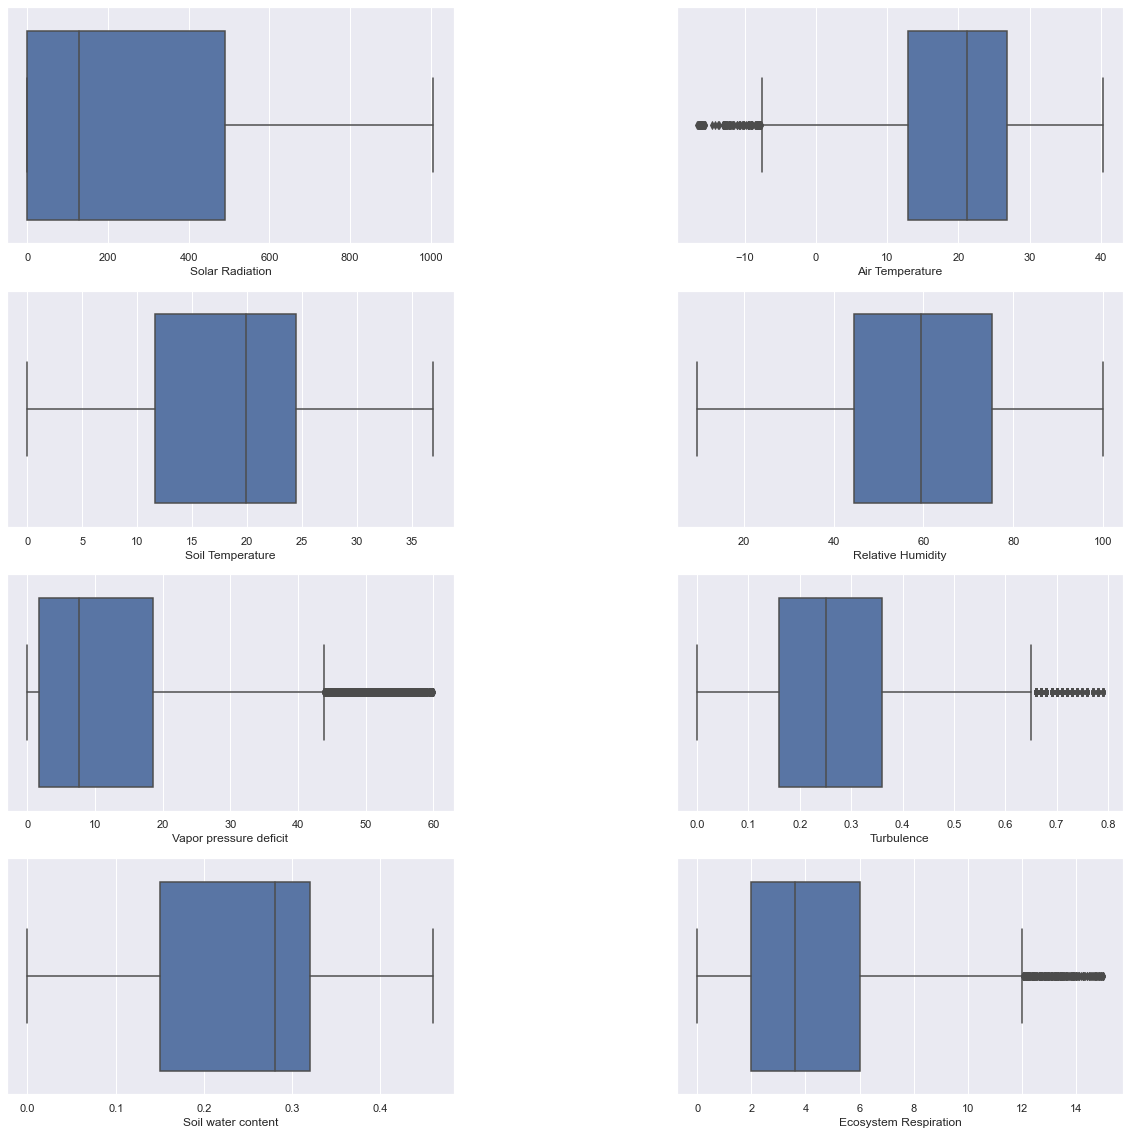

In [82]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize = (20, 20))


plt.subplots_adjust(wspace=0.5) 
#create boxplot in each subplot
a=sns.boxplot(data=df, x='Rg',  ax=axes[0,0])
b=sns.boxplot(data=df, x='Tair',ax=axes[0,1])
c=sns.boxplot(data=df, x='Tsoil', ax=axes[1,0])
d=sns.boxplot(data=df, x='rH', ax=axes[1,1])
e=sns.boxplot(data=df, x='VPD',ax=axes[2,0])
f=sns.boxplot(data=df, x='Ustar',ax=axes[2,1])
g=sns.boxplot(data=df, x='SWC', ax=axes[3,0])
h=sns.boxplot(data=df, x='ER', ax=axes[3,1])


a.set_xlabel( "Solar Radiation")
b.set_xlabel( "Air Temperature")
c.set_xlabel( "Soil Temperature")
d.set_xlabel( "Relative Humidity")
e.set_xlabel( "Vapor pressure deficit")
f.set_xlabel( "Turbulence")
g.set_xlabel( "Soil water content")
h.set_xlabel( "Ecosystem Respiration")




In [83]:
sns.set_context("paper", font_scale=1.4)

### Pairplot visualization

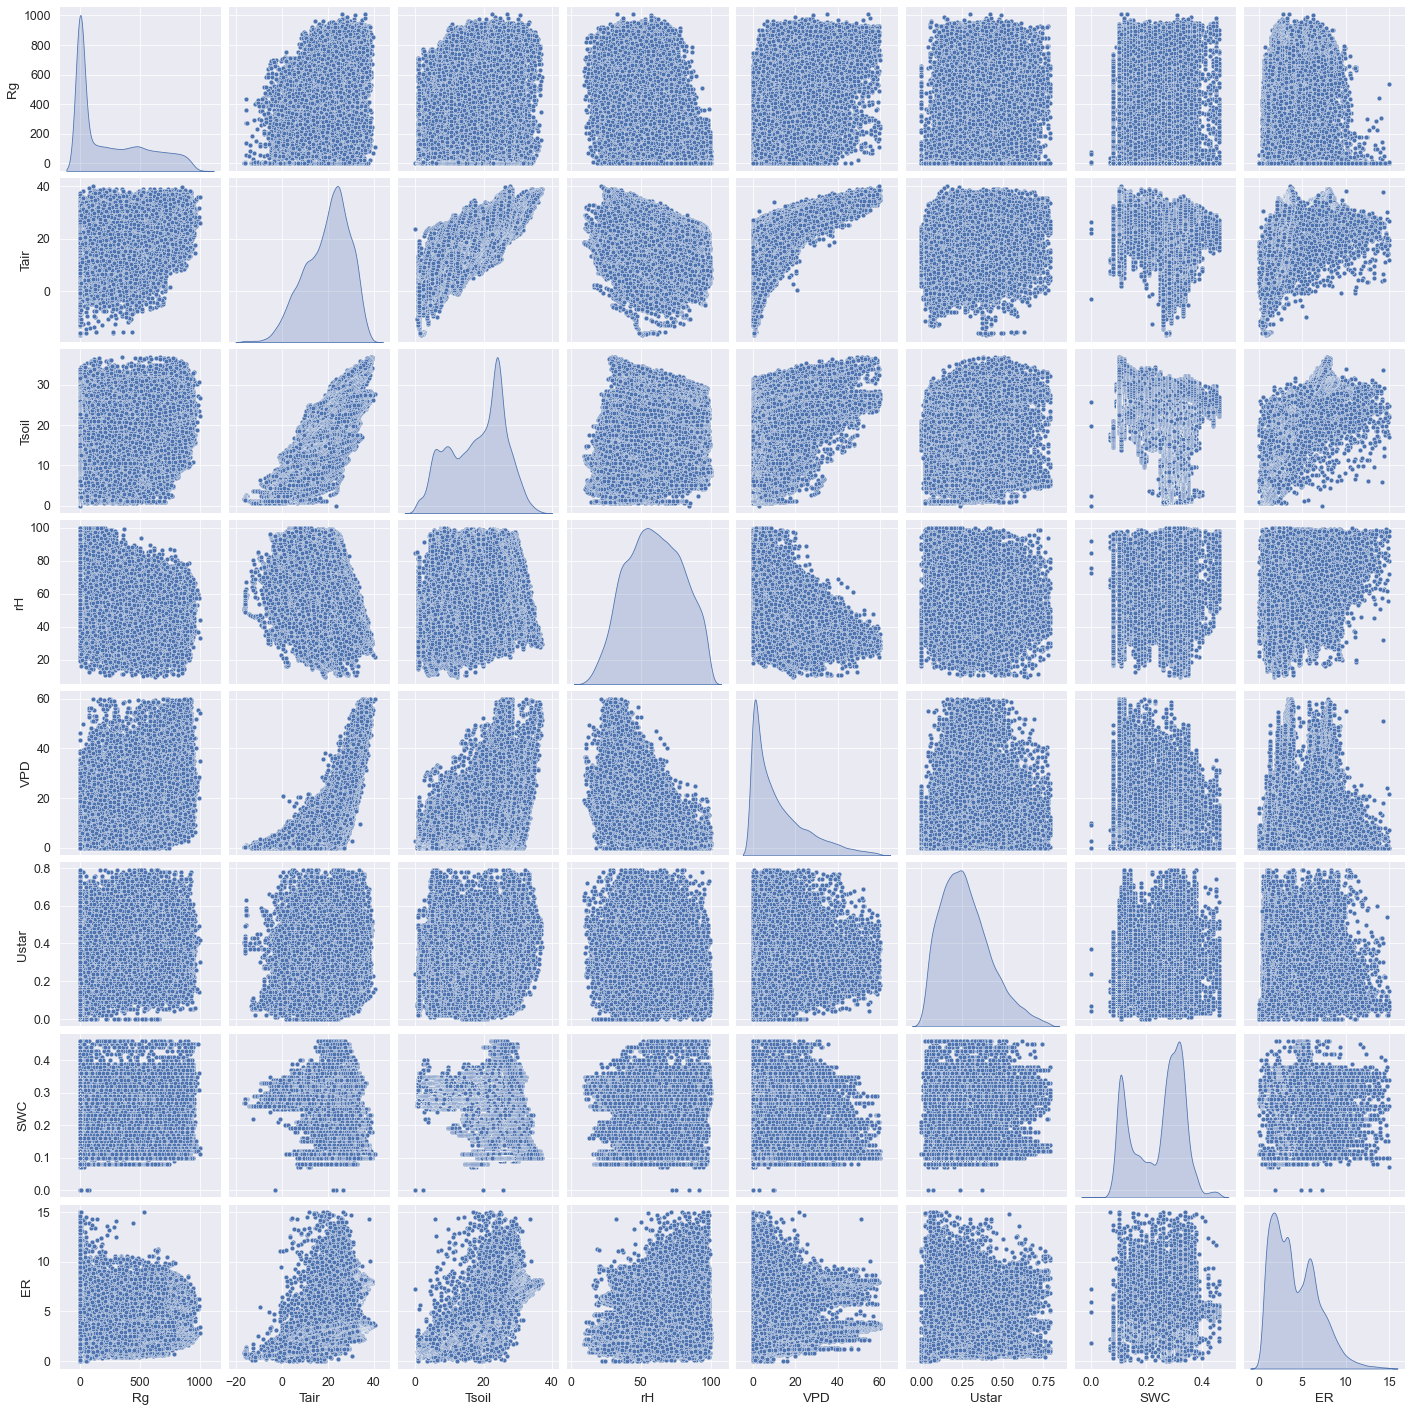

In [84]:
sns.pairplot(data=df[['Rg', 'Tair', 'Tsoil', 'rH', 'VPD',
       'Ustar', 'SWC','ER']], diag_kind='kde')

## Remove few more outliers

In [85]:

index=list(np.where((df['VPD']>40) & (df['ER']>12.5)))
index

[array([3535], dtype=int64)]

In [86]:
index=list(np.where((df['SWC']<=0.0) & (df['ER']<=7.5)))
index

[array([ 1311, 12143, 15194, 19576], dtype=int64)]

In [87]:
x=list(np.where((df['Rg']>400) & (df['ER']>12.5)))
index=[3535, 1311, 12143, 15194, 19576,25492,9670]
x

[array([ 9670, 25492], dtype=int64)]

In [88]:
df = df.drop([df.index[i] for i in index])


In [89]:
np.where((df['ER']>11) & (df['Rg']>400))

(array([5963, 5964, 5999, 6000], dtype=int64),)

In [90]:
index=[5963, 5964, 5999, 6000]
df = df.drop([df.index[i] for i in index])

## Missing value imputation
1. if distribution is Normal - fill missing values with mean.
2. if distribution is Skewed - fill missing values with median.

In [91]:
df['Rg'] = df['Rg'].fillna(df['Rg'].median())
df['Tair'] = df['Tair'].fillna(df['Tair'].mean())
df['Tsoil'] = df['Tsoil'].fillna(df['Tsoil'].mean())
df['rH'] = df['rH'].fillna(df['rH'].mean())

df['SWC'] = df['SWC'].fillna(df['SWC'].mean())


## Pairplot visualization after Cleaning data.

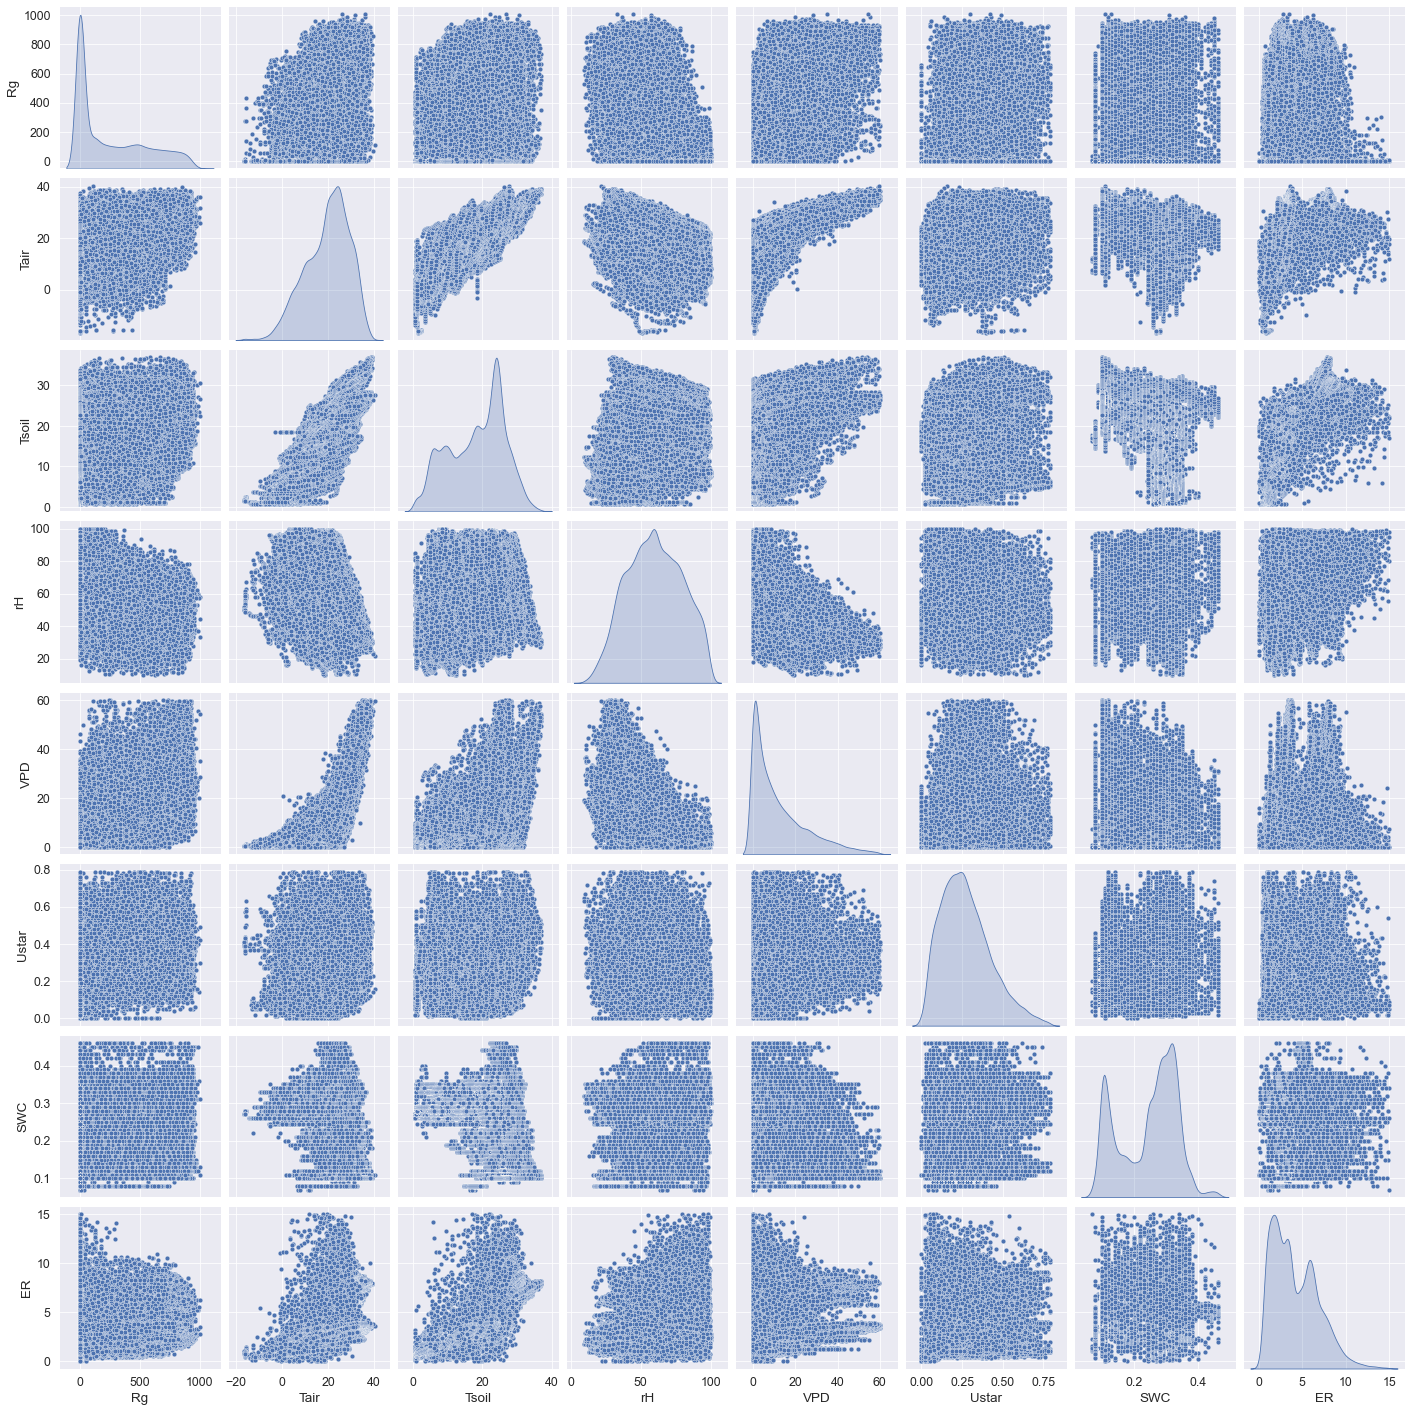

In [92]:
sns.pairplot(data=df[['Rg', 'Tair', 'Tsoil', 'rH', 'VPD',
       'Ustar', 'SWC','ER']], diag_kind='kde')

## Correlation plot

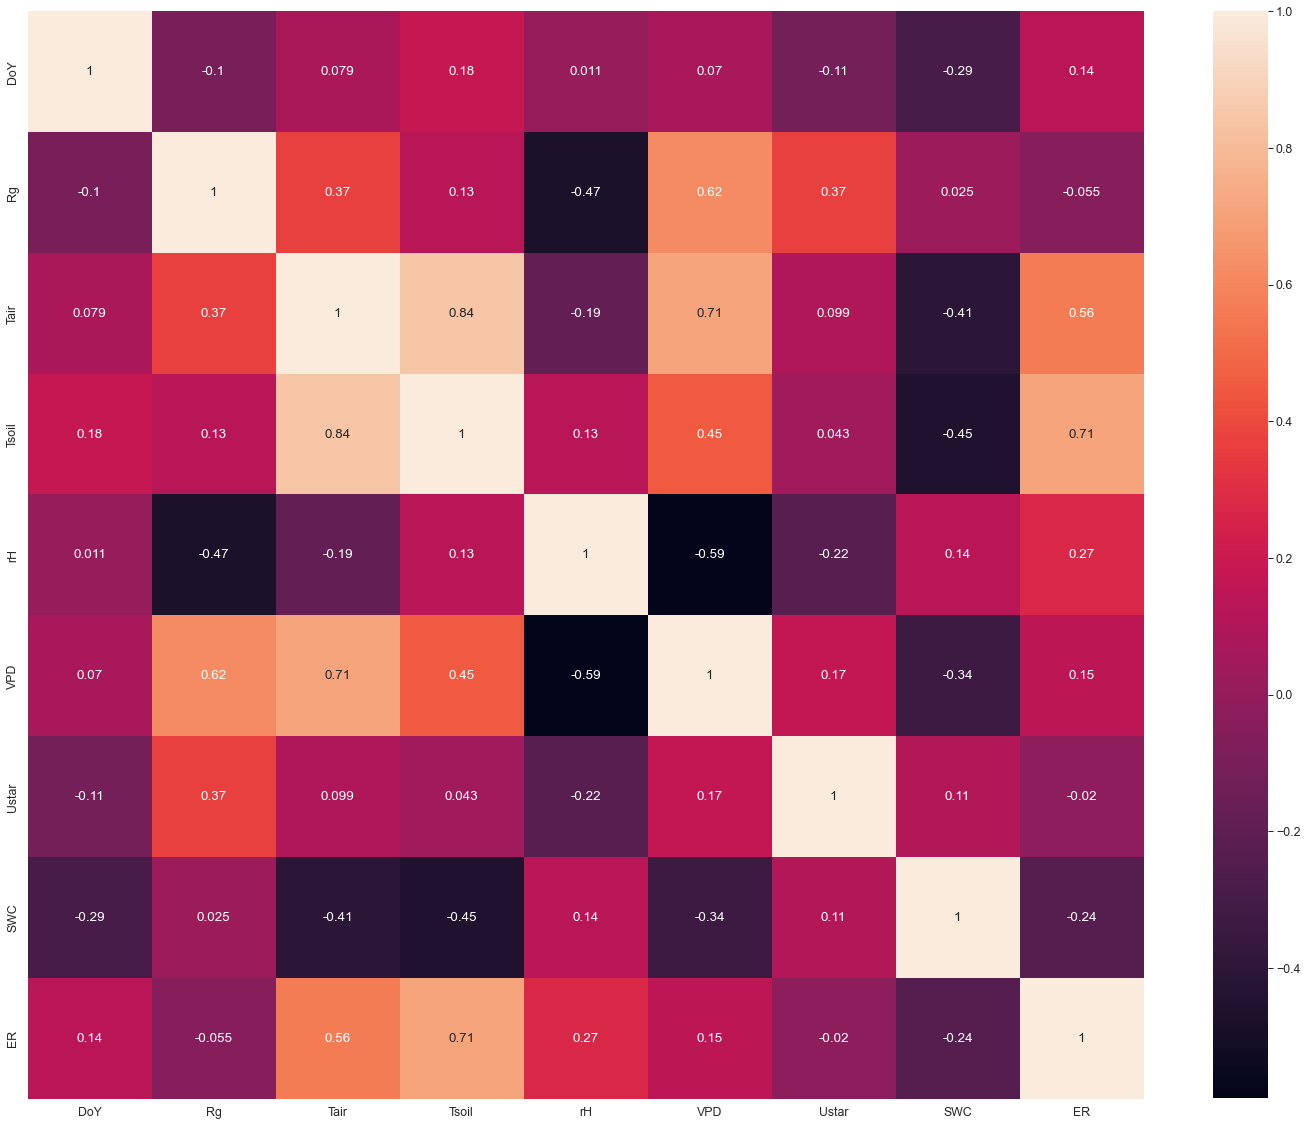

In [93]:
corr_matrix = df[['DoY','Rg', 'Tair', 'Tsoil', 'rH', 'VPD',
       'Ustar', 'SWC','ER']].corr()
plt.figure(figsize=(25,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [94]:
d = df[['Rg', 'Tair', 'Tsoil', 'rH', 'VPD',
       'Ustar', 'SWC','ER']]
d.describe()

Rg          Tair         Tsoil            rH           VPD  \
count  29586.000000  29586.000000  29586.000000  29586.000000  29586.000000   
mean     256.852298     19.632038     18.371029     59.768618     12.071701   
std      292.266593      9.496737      7.892328     19.566660     12.986571   
min        0.000000    -16.660000      0.710000      9.600000      0.000000   
25%        0.000000     13.110000     11.700000     44.850000      1.730000   
50%      126.925000     21.010000     19.740000     59.768618      7.550000   
75%      485.960000     26.687500     24.390000     74.990000     18.557500   
max     1006.340000     40.270000     36.950000    100.000000     59.990000   

              Ustar           SWC            ER  
count  29586.000000  29586.000000  29586.000000  
mean       0.272822      0.243969      4.166194  
std        0.152384      0.088659      2.619989  
min        0.000000      0.070000      0.000000  
25%        0.160000      0.160000      1.982900  
50%        0.250000      0.270000      3.600000  
75%        0.360000      0.310000      5.994375  
max        0.790000      0.460000     14.980000

In [95]:
# Input variables.
X = df[['Rg', 'Tair', 'Tsoil', 'rH', 'VPD',
       'SWC']]

# Target variable
y = df['ER']


# Train-Test split data : 80% train data, 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Model Training

### Random forest without hyperparameter tuning

In [97]:
# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Calculate the MSE and R2 score on the testing set
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print('MSE:', mse)
print('RMSE:', rmse)
print('R2 score:', r2)
print('MAE:', mae)

MSE: 1.387185658054753
RMSE: 1.177788460656137
R2 score: 0.8011630153924996
MAE: 0.6299845546055883


### Standardisation and Normalization

In [98]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
scaler_stand = StandardScaler()
X_train_stand = scaler_stand.fit_transform(X_train)
X_test_stand = scaler_stand.transform(X_test)

### KNN model without tuning

In [99]:

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7,weights='distance')

rmse = []
mse=[]
r2=[]
mae=[]

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]


for i in range(len(trainX)):
    
    # fit
    knn.fit(trainX[i],y_train)
    # predict
    ky_pred = knn.predict(testX[i])
    # RMSE
    rmse.append(mean_squared_error(y_test, ky_pred, squared=False))
    mse.append(mean_squared_error(y_test, ky_pred))
    r2.append(r2_score(y_test, ky_pred))
    mae = mean_absolute_error(y_test, ky_pred)

# visualizing the result
df_knn = pd.DataFrame({'RMSE':rmse,'MSE':mse,'R2':r2,'MAE':mae},index=['Original','Normalized','Standardized'])
df_knn

RMSE       MSE        R2       MAE
Original      1.580104  2.496729  0.642123  0.720502
Normalized    1.290020  1.664153  0.761463  0.720502
Standardized  1.283288  1.646827  0.763946  0.720502

### SVR model without tuning

In [100]:
# training an SVR model
from  sklearn.svm import SVR


# SVR
svr = SVR(kernel='rbf',C=5)

rmse = []
mse=[]
r2=[]

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    svr.fit(trainX[i],y_train)
    # predict
    sy_pred = svr.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,sy_pred)))
    mse.append(mean_squared_error(y_test, sy_pred))
    r2.append(r2_score(y_test, sy_pred))

# visualizing the result
df_svr = pd.DataFrame({'RMSE':rmse,'MSE':mse,'R2':r2},index=['Original','Normalized','Standardized'])
df_svr

RMSE       MSE        R2
Original      1.718001  2.951529  0.576933
Normalized    1.493385  2.230199  0.680327
Standardized  1.459290  2.129527  0.694757

### Random Forest model without tuning

In [31]:

rfg = RandomForestRegressor(max_depth=20, n_estimators=1000,
                      random_state=42)

rmse = []
mse=[]
r2=[]

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    rfg.fit(trainX[i],y_train)
    # predict
    y_pred = rfg.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    mse.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))

# visualizing the result
df_rfg = pd.DataFrame({'RMSE':rmse,'MSE':mse,'R2':r2},index=['Original','Normalized','Standardized'])
df_rfg

RMSE       MSE        R2
Original      1.182977  1.399435  0.799407
Normalized    1.183608  1.400929  0.799193
Standardized  1.183358  1.400336  0.799278

### Random Forest with hyper-parameter tuning

#### GridsearchCv

In [34]:
from sklearn.model_selection import GridSearchCV

cv_rfg = RandomForestRegressor()
# Find the best parameters for the model
parameters = {
    'max_depth': [10, 20, 30, 50],
    'n_estimators': [100, 500, 1000,1500],
    'bootstrap' : [True, False],
    'min_samples_split': [2,5, 10, 12],
    
}
gridforest = GridSearchCV(cv_rfg, parameters, cv = 5, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)

# Best parameters
gridforest.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_split': 5,
 'n_estimators': 1500}

In [78]:
# load the model to pickle file.
import pickle
with open('random_forest_ER.pkl', 'wb') as f:
    pickle.dump(gridforest.best_estimator_, f)

In [38]:
gridforest.best_estimator_

RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=1500)

In [39]:
## Random Forest model Results after hyper-parameter tuning
rfg = RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=1500)

rmse = []
mse=[]
r2=[]

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

# model fitting and measuring RMSE,MSE and R2.
for i in range(len(trainX)):
    
    # fit
    rfg.fit(trainX[i],y_train)
    # predict
    y_pred = rfg.predict(testX[i])
    # RMSE, MSE and R2
    rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    mse.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))

# visualizing the result
df_rfg = pd.DataFrame({'RMSE':rmse,'MSE':mse,'R2':r2},index=['Original','Normalized','Standardized'])
df_rfg

RMSE       MSE        R2
Original      1.179156  1.390410  0.800701
Normalized    1.178380  1.388578  0.800963
Standardized  1.178270  1.388320  0.801000

In [82]:
rfg = RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=1500)

rmse = []
mse=[]
r2=[]

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    rfg.fit(trainX[i],y_train)
    # predict
    y_pred = rfg.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    mse.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))

# visualizing the result
df_rfg = pd.DataFrame({'RMSE':rmse,'MSE':mse,'R2':r2},index=['Original','Normalized','Standardized'])
df_rfg

RMSE       MSE        R2
Original      1.178174  1.388095  0.801033
Normalized    1.178893  1.389788  0.800790
Standardized  1.177893  1.387432  0.801128

No handles with labels found to put in legend.


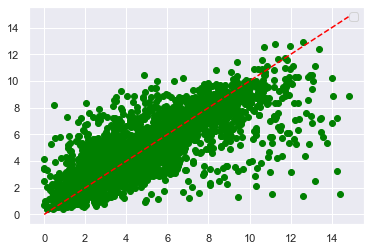

In [88]:
# Random Forest test data vs predict data.
plt.scatter(y_test, y_pred, color = 'green')

# Add a diagonal line to represent perfect predictions
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')

plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ER'>

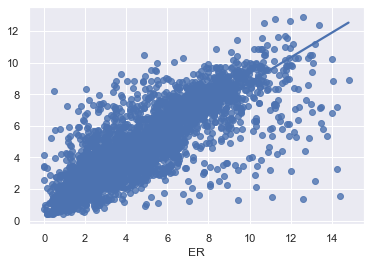

In [89]:
sns.regplot(y_test, y_pred, ci=None)

In [88]:
## Decision Tree model.

from sklearn.tree import DecisionTreeRegressor

# Decision tree
dt_model = DecisionTreeRegressor(random_state = 42)

rmse = []
mse=[]
r2=[]

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    dt_model.fit(trainX[i],y_train)
    # predict
    dty_pred = dt_model.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,dty_pred)))
    mse.append(mean_squared_error(y_test, dty_pred))
    r2.append(r2_score(y_test, dty_pred))

# visualizing the result
df_dtr = pd.DataFrame({'RMSE':rmse,'MSE':mse,'R2':r2},index=['Original','Normalized','Standardized'])
df_dtr

RMSE       MSE        R2
Original      1.621130  2.628064  0.623298
Normalized    1.619796  2.623739  0.623917
Standardized  1.620848  2.627148  0.623429

## Regression plots for different models

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anacond

IndexError: index 2 is out of bounds for axis 1 with size 2

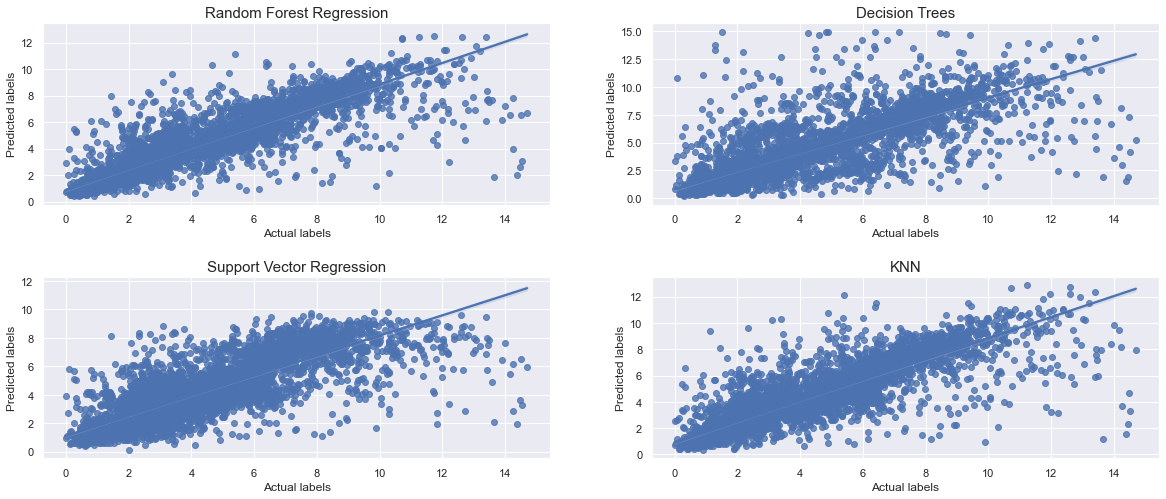

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a figure with 2 subplots arranged in a 1x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 8))



# Plot the second regression model in the second subplot
sns.regplot(y_test, y_pred, data=df, ax=axs[0,0])
axs[0,0].set_xlabel('Actual labels')
axs[0,0].set_ylabel('Predicted labels')
axs[0,0].set_title('Random Forest Regression')
axs[0,0].title.set_size(15)


sns.regplot(y_test, dty_pred, data=df, ax=axs[0,1])
axs[0,1].set_xlabel('Actual labels')
axs[0,1].set_ylabel('Predicted labels')
axs[0,1].set_title('Decision Trees')
axs[0,1].title.set_size(15)


sns.regplot(y_test, sy_pred, data=df, ax=axs[1,0])
axs[1,0].set_xlabel('Actual labels')
axs[1,0].set_ylabel('Predicted labels')
axs[1,0].set_title('Support Vector Regression')
axs[1,0].title.set_size(15)


sns.regplot(y_test, ky_pred, data=df, ax=axs[1,1])
axs[1,1].set_xlabel('Actual labels')
axs[1,1].set_ylabel('Predicted labels')
axs[1,1].set_title('KNN')
axs[1,1].title.set_size(15)



# Add a title for the whole figure
fig.subplots_adjust(hspace=0.4)

fig.delaxes(axs[1,1])
# Show the plot
plt.show()